In [1]:
from datetime import datetime
import time
import os
import sys
import copy

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
# from sklearn.model_selection import train_test_split, KFold

from tqdm import tqdm
from matplotlib import pyplot as plt
# import seaborn as sns
# import plotly.express as px

from zipfile import ZipFile

In [3]:
# from torchmetrics import F1, Accuracy
# import timm

In [4]:
from FaceMaskData import FaceMaskData
from FaceMaskDataset import FaceMaskDataset

In [5]:
%load_ext tensorboard 

In [6]:
assert torch.cuda.is_available()

In [7]:
class CFG:
    seed = 42
    model_name = 'efficientnet_b4'
    pretrained = True
    # img_width = 384
    # img_height = 256
    batch_size = 1
    n_epochs = 10
    n_folds = 5
    drop_rate = 0.4
    train_size = 0.85
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

np.random.seed(CFG.seed)

# IMG_WIDTH, IMG_HEIGHT = 256, 170
# IMG_WIDTH, IMG_HEIGHT = 384, 256
# IMG_WIDTH, IMG_HEIGHT = 512, 342
# IMG_WIDTH, IMG_HEIGHT = 640, 426

In [8]:
# train_transforms = transforms.Compose([
#     transforms.CenterCrop(10),
#     transforms.ToTensor(),
#     transforms.RandomRotation(90),
# ])

# train_transforms = A.Compose([
#     A.RandomCrop(width=450, height=450),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ], bbox_params=A.BboxParams(format='coco', min_visibility=0.1, label_fields=['labels']))


train_transforms = A.Compose([
    
#     A.HueSaturationValue(p=0.5),
#     A.Flip(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(p=0.5, shift_limit=(-0.1, 0.3), scale_limit=(-0.1, 0.6), rotate_limit=(-90, 90), interpolation=0, border_mode=2),
#     A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
#     A.OneOf([
#         A.Blur(p=0.7),
#         A.GaussNoise(p=0.7, var_limit=(100, 400)),
#         A.MotionBlur(p=0.7),
#         A.ISONoise(p=0.7),
#     ], p=0.5),
    A.Resize(width=224, height=224, interpolation=cv2.INTER_LINEAR, always_apply=True, p=1),
    ToTensorV2(),
    
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

valid_transforms = A.Compose([
    
    A.Resize(width=224, height=224, interpolation=cv2.INTER_LINEAR, always_apply=True, p=1),
    ToTensorV2(),
    
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [9]:
imgs_path = './images'
msks_path = './annotation.csv'

faceMasksData = FaceMaskData(imgs_path, msks_path)
(x_train, y_train), (x_test, y_test) = faceMasksData.load_data()

trainset = FaceMaskDataset(x_train, y_train, imgs_path, transforms=train_transforms)
validset = FaceMaskDataset(x_test, y_test, imgs_path, transforms=valid_transforms)

print('Training contains {} samples which is {:g}% of the data'.format(len(trainset), len(trainset) * 100 / (len(trainset) + len(validset))))
print('Validation contains {} samples which is {:g}% of the data'.format(len(validset), len(validset) * 100 / (len(trainset) + len(validset))))

Training contains 682 samples which is 79.9531% of the data
Validation contains 171 samples which is 20.0469% of the data


In [10]:
train_loader = DataLoader(dataset=trainset, batch_size=CFG.batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=validset, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

In [11]:
dataloaders = { 'train': train_loader,
                'valid': valid_loader }

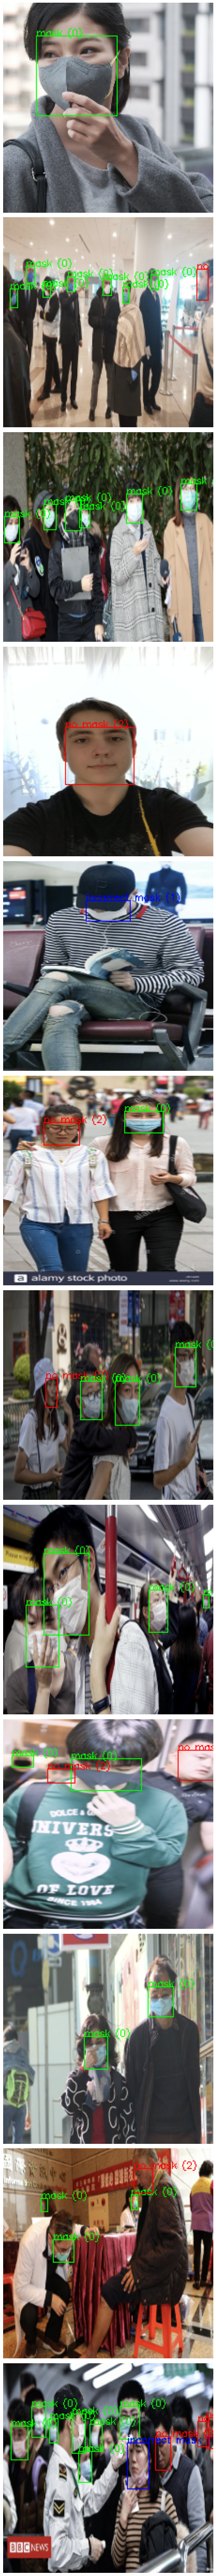

In [12]:
def norm(img):
    img = np.array(img, dtype=np.float32)
    img -= img.min()
    img /= img.max()
    return img

def show_augmented_samples(dataset, model=None):
    plt.figure(figsize=(10, 80))
    
    amount_samples = 12
    
    for i, idx in enumerate(np.random.choice(range(len(dataset)), amount_samples)):
        img, target = dataset[idx]
        plt.subplot(amount_samples, 1, i + 1)
        plt.axis('off')
        
        img = np.array(img, dtype=np.int32)
        img = np.transpose(img, (1, 2, 0))
        
        for box, cat in zip(target['bboxes'], target['labels']):
            xmin, ymin, xmax, ymax = np.array(box, dtype=np.int32)
            start_point = (xmin, ymin)
            end_point = (xmax, ymax)
            
            color = (0, 0, 0)
            if cat == 0:
                color = (0, 255, 0)
            elif cat == 1:
                color = (0, 0, 255)
            elif cat == 2:
                color = (255, 0, 0)
            thickness = 1
            img = cv2.rectangle(img, start_point, end_point, color, thickness)

            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1 / 3
            img = cv2.putText(img, '{} ({})'.format(validset.decode(cat), int(cat)), start_point, font, fontScale, color, thickness, cv2.LINE_AA)
        plt.imshow(norm(img))  
    plt.tight_layout()
    plt.show()

show_augmented_samples(trainset)

In [13]:
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005,
#                                 momentum=0.9, weight_decay=0.0005)

In [24]:
def train(model, loaders, optimizer, epochs, writers, path):
    print('This running path is: `{}`\n'.format(path))
    time.sleep(1)
    device = CFG.device

    model = model.to(device)

    best_loss = 100000

    for epch in range(1, epochs + 1):              #   iterate epoch
        print('Epoch {:3d}:'.format(epch), flush=True)
        
        loss_sub_list = []
        
        epoch_print = '\n'
        for phase in ['train', 'valid']:    #   iterate phases
            if phase == 'train':
                model.train()
            else:
                model.eval()
            torch.autograd.set_grad_enabled(phase == 'train')

            with tqdm(total=len(loaders[phase]), desc=phase) as progress_bar:               #   define progress bas
                running_loss, samples = 0.0, 0      #   reset epoch-phase metrics
                for x_batch, y_batch in loaders[phase]:                                     #   iterate batches
                    x_batch  = x_batch.float().to(device)
                    samples += x_batch.size(0)              #   count samples to average the epoch loss
                    optimizer.zero_grad()
                    
                    targets = [{k:v.to(device) for k,v in t.items()} for t in y_batch]
                    
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    running_loss      += loss.item()
                    
                    if phase == 'train':
                        optimizer.zero_grad()
                        losses.backward()
                        optimizer.step()

                    del x_batch
                    del y_batch
                    del output
                    del loss
                    torch.cuda.empty_cache()
                    progress_bar.update(1)
                
                if phase == 'train' and scheduler is not None:
                    writers['train'].add_scalar('lr epoch', scheduler.get_last_lr()[0], epch)
                    scheduler.step()

            epch_loss   = running_loss / samples

            writers[phase].add_scalar('loss epoch', epch_loss, epch)

            statistics = statistics.append({    'phase' : phase,
                                                'epoch' : epch,
                                                'loss'  : epch_loss,
                                            }, ignore_index=True)

            epoch_print += '{0} loss: {1:.6f}\t{0}\n'.format(
                            phase,
                            epch_loss,
                        )
        
        print(epoch_print, flush=True)
        
        #   if the model perform better in this epoch, save it's parameters
        if epch_loss < best_loss:
            best_loss = epch_loss
#             torch.save(model.state_dict(), path)

In [25]:
logs_folder = os.path.join(sys.path[0], 'logs')

In [26]:
writer_train_epoch = SummaryWriter('{}/{}_train'.format(logs_folder, CFG.model_name))
writer_valid_epoch = SummaryWriter('{}/{}_valid'.format(logs_folder, CFG.model_name))

epoch_writers = { 'train': writer_train_epoch,
                  'valid': writer_valid_epoch }

In [27]:
num_classes = 3

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs=30

In [28]:
train(model, dataloaders, optimizer, num_epochs, epoch_writers, 'path')

This running path is: `path`

Epoch   1:


train:   0%|                                                                                                                                                            | 0/682 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'items'